In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from transformers import SamModel, SamProcessor
from torch import nn
import torch.optim as optim
from tqdm import tqdm

class SAMUltrasoundDataset(Dataset):
    def __init__(self, csv_file, base_path, split="train", image_size=256):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data["Split"].str.lower() == split.lower()]
        self.base_path = base_path
        self.image_size = image_size
        
        self.image_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])
        self.mask_transform = T.Compose([
            T.Resize((image_size, image_size)), 
            T.ToTensor()
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = row["FileName"].strip() + ".png"
        image_path = os.path.join(self.base_path, filename.lstrip("/"))
        mask_path = image_path.replace("/frames/", "/mask/")
        
        # Load images
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") 
        
        orig_w, orig_h = image.size
        
        image_tensor = self.image_transform(image)
        mask_tensor = self.mask_transform(mask)
        mask_tensor = (mask_tensor > 0.5).float()
        
        # scale
        scaled_x = int(row["x"] * self.image_size / orig_w)
        scaled_y = int(row["y"] * self.image_size / orig_h)
        
        return {
            "image": image_tensor,
            "mask": mask_tensor,
            "point_coords": [[scaled_x, scaled_y]],
            "image_path": image_path
        }

def sam_collator(batch):
    images = [b["image"] for b in batch]
    masks = torch.stack([b["mask"] for b in batch])
    
    if len(masks.shape) == 3:
        masks = masks.unsqueeze(1) 
    
    coords = [b["point_coords"] for b in batch]
    
    return {
        "images": images,
        "masks": masks,
        "point_coords": coords
    }


In [6]:
def train_epoch(model, processor, dataloader, optimizer, device, epoch, gradient_accumulation_steps=1):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(progress_bar):
        try:
            images = batch["images"]
            masks = batch["masks"].to(device)
            point_coords = batch["point_coords"]
            
            images_np = [img.permute(1, 2, 0).cpu().numpy() for img in images]
            
            inputs = processor(
                images=images_np,
                input_points=point_coords,
                return_tensors="pt",
                do_rescale=False,
                padding="longest"
            ).to(device)
            
            outputs = model(**inputs, multimask_output=False)
            pred_masks = outputs.pred_masks.squeeze(1)
            
            if masks.shape != pred_masks.shape:
                masks = torch.nn.functional.interpolate(
                    masks.float(), 
                    size=pred_masks.shape[-2:], 
                    mode='nearest'
                )
            
            loss = nn.functional.binary_cross_entropy_with_logits(pred_masks, masks)
            loss = loss / gradient_accumulation_steps 
            
            loss.backward()
            
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            total_loss += loss.item() * gradient_accumulation_steps
            
            progress_bar.set_postfix({
                'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
                'avg_loss': f'{total_loss / (batch_idx + 1):.4f}'
            })
            
        except torch.cuda.OutOfMemoryError:
            print(f"CUDA OOM error at batch {batch_idx}. Skipping batch...")
            torch.cuda.empty_cache()
            continue
        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            continue
    
    # handle remaining gradient
    if (batch_idx + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / num_batches
    return avg_loss

def validate_epoch(model, processor, dataloader, device, epoch):
    model.eval()
    total_loss = 0
    num_batches = len(dataloader)
    
    progress_bar = tqdm(dataloader, desc=f"Validation {epoch}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(progress_bar):
            try:
                images = batch["images"]
                masks = batch["masks"].to(device)
                point_coords = batch["point_coords"]
                
                images_np = [img.permute(1, 2, 0).cpu().numpy() for img in images]
                
                inputs = processor(
                    images=images_np,
                    input_points=point_coords,
                    return_tensors="pt",
                    do_rescale=False,
                    padding="longest"
                ).to(device)
                
                outputs = model(**inputs, multimask_output=False)
                pred_masks = outputs.pred_masks.squeeze(1)
                
                if masks.shape != pred_masks.shape:
                    masks = torch.nn.functional.interpolate(
                        masks.float(), 
                        size=pred_masks.shape[-2:], 
                        mode='nearest'
                    )
                
                loss = nn.functional.binary_cross_entropy_with_logits(pred_masks, masks)
                total_loss += loss.item()
                
                progress_bar.set_postfix({
                    'val_loss': f'{loss.item():.4f}',
                    'avg_val_loss': f'{total_loss / (batch_idx + 1):.4f}'
                })
                
            except torch.cuda.OutOfMemoryError:
                print(f"CUDA OOM error at validation batch {batch_idx}. Skipping batch...")
                torch.cuda.empty_cache()
                continue
            except Exception as e:
                print(f"Error processing validation batch {batch_idx}: {e}")
                continue
    
    avg_loss = total_loss / num_batches
    return avg_loss

def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to {filepath}")

def load_checkpoint(model, optimizer, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filepath}, epoch {epoch}, loss {loss:.4f}")
    return epoch, loss
    
    

In [10]:
# csv_path = "medivs2_project/filelist_frames_dataset.csv"
csv_path = "./filelist_frames_dataset.csv"
# base_path = "/home/jovyan/.cache/kagglehub/datasets/foghorn/echonet-frames-masks-dataset/versions/1/Echonet-Frames-Masks-Dataset/"
base_path = "./Echonet-Frames-Masks-Dataset/"
image_size = 1024

num_epochs = 3
batch_size = 1
gradient_accumulation_steps = 16
learning_rate = 1e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")

train_dataset = SAMUltrasoundDataset(csv_path, base_path, split="TRAIN", image_size=image_size)
val_dataset = SAMUltrasoundDataset(csv_path, base_path, split="VAL", image_size=image_size)
test_dataset = SAMUltrasoundDataset(csv_path, base_path, split="TEST", image_size=image_size)

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=sam_collator,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=sam_collator,
    num_workers=0,
    pin_memory=False
)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

checkpoint_dir = "./sam_ultrasound_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Using device: cuda
GPU memory allocated: 0.71 GB
GPU memory cached: 0.77 GB
Training dataset size: 15048
Validation dataset size: 3000
Training batches: 15048
Validation batches: 3000


In [ ]:
best_val_loss = float('inf')
    
for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
    
    train_loss = train_epoch(
        model, processor, train_loader, optimizer, device, 
        epoch + 1, gradient_accumulation_steps
    )
    
    val_loss = validate_epoch(model, processor, val_loader, device, epoch + 1)
    
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pt")
    save_checkpoint(model, optimizer, epoch + 1, val_loss, checkpoint_path)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_checkpoint_path = os.path.join(checkpoint_dir, "best_model.pt")
        save_checkpoint(model, optimizer, epoch + 1, val_loss, best_checkpoint_path)
        print(f"New best model saved with validation loss: {val_loss:.4f}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

In [3]:
from scipy.ndimage import zoom



def run_sam_inference(dataset, model, processor, device, num_examples=3, batch_size=1):
    model.eval()
    
    for i in range(0, num_examples, batch_size):
        end_idx = min(i + batch_size, num_examples)
        batch_indices = range(i, end_idx)
        
        batch_images = []
        batch_coords = []
        batch_samples = []
        
        for idx in batch_indices:
            sample = dataset[idx]
            batch_images.append(sample["image"])
            batch_coords.append(sample["point_coords"])
            batch_samples.append(sample)
        
        try:
            inputs = processor(
                images=batch_images,
                input_points=batch_coords,
                return_tensors="pt",
                do_rescale=False,
                padding="longest"
            ).to(device)
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            pred_masks = outputs.pred_masks.cpu()
            
            for j, (sample, pred_mask) in enumerate(zip(batch_samples, pred_masks)):
                actual_idx = i + j
                print(f"\n--- Sample {actual_idx + 1} ---")
                print(f"Image shape: {sample['image'].shape}")
                print(f"Point coordinates: {sample['point_coords']}")
                print(f"Raw predicted mask shape: {pred_mask.shape}")
                
                show_mask_and_image(
                    image_tensor=sample["image"],
                    pred_mask=pred_mask.squeeze(),
                    true_mask=sample["mask"].squeeze(),
                    title=sample["image_path"],
                    coords=sample["point_coords"]
                )
                
        except torch.cuda.OutOfMemoryError:
            print(f"CUDA OOM error with batch size {batch_size}. Try reducing batch_size.")
            torch.cuda.empty_cache()
            break
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue
        
        torch.cuda.empty_cache()

def show_mask_and_image(image_tensor, pred_mask, true_mask, title, coords):
    image = image_tensor.permute(1, 2, 0).numpy()
    image_h, image_w = image.shape[:2]
    
    plt.figure(figsize=(15, 5))
    
    # input image
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.scatter(coords[0][0], coords[0][1], c='red', s=50, marker='*')
    plt.title("Original Image + Point")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    medsam_seg_prob = torch.sigmoid(pred_mask).numpy()
    
    if len(medsam_seg_prob.shape) == 3:
        mask_2d = medsam_seg_prob[0]
    else:
        mask_2d = medsam_seg_prob
    
    binary_mask = (mask_2d > 0.5).astype(np.float32)
    
    if binary_mask.shape != (image_h, image_w):
        scale_y = image_h / binary_mask.shape[0]
        scale_x = image_w / binary_mask.shape[1]
        binary_mask = zoom(binary_mask, (scale_y, scale_x), order=0)  # nearest neighbor
    
    plt.imshow(binary_mask, cmap="gray")
    plt.title(f"Predicted Mask (Binary)\nShape: {binary_mask.shape}")
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    true_mask_np = true_mask.numpy()
    if len(true_mask_np.shape) == 3:
        true_mask_np = true_mask_np[0]
    
    true_binary = (true_mask_np > 0.5).astype(np.float32)
    
    if true_binary.shape != (image_h, image_w):
        scale_y = image_h / true_binary.shape[0]
        scale_x = image_w / true_binary.shape[1]
        true_binary = zoom(true_binary, (scale_y, scale_x), order=0)
    
    plt.imshow(true_binary, cmap="gray")
    plt.title(f"Ground Truth Mask (Binary)\nShape: {true_binary.shape}")
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(image)
    colored_mask = np.zeros((*binary_mask.shape, 4))  # RGBA
    colored_mask[binary_mask > 0.5] = [1, 0, 0, 0.6]  # Red with alpha
    plt.imshow(colored_mask)
    plt.scatter(coords[0][0], coords[0][1], c='yellow', s=50, marker='*', edgecolors='black')
    plt.title("Overlay")
    plt.axis('off')
    
    print(f"Image shape: {image.shape}")
    print(f"Original pred mask shape: {medsam_seg_prob.shape}")
    print(f"Final binary mask shape: {binary_mask.shape}")
    print(f"Mask coverage: {np.sum(binary_mask > 0.5)} pixels")
    
    plt.suptitle(os.path.basename(title), fontsize=10)
    plt.tight_layout()
    plt.show()

Checkpoint loaded from ./best_model.pt, epoch 5, loss 0.0256

--- Sample 1 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[566, 390]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 150081 pixels


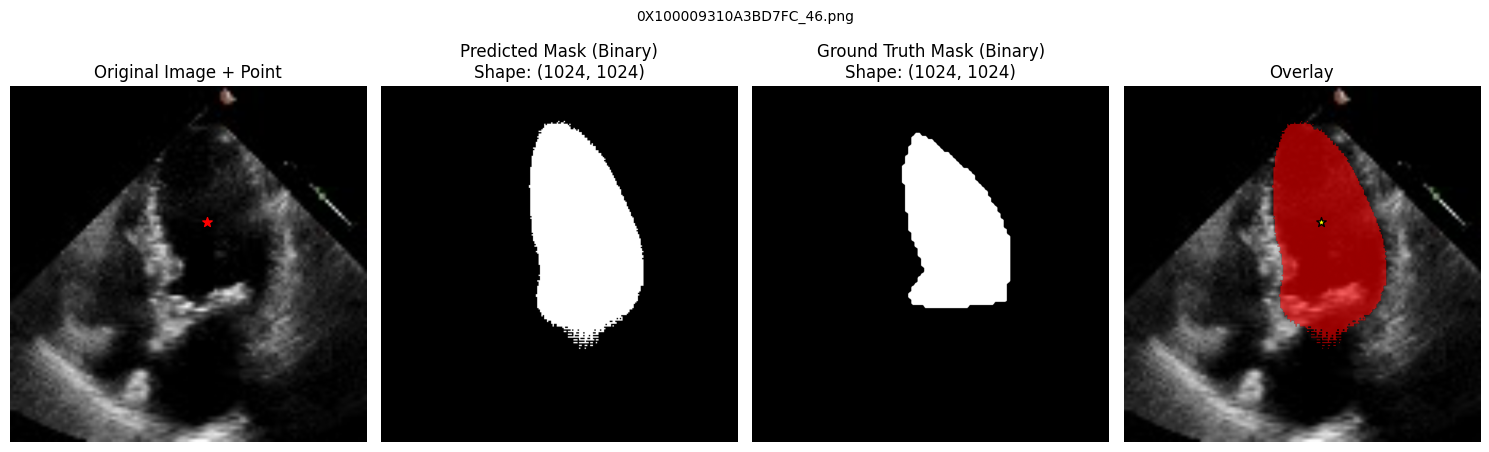


--- Sample 2 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[599, 537]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 156397 pixels


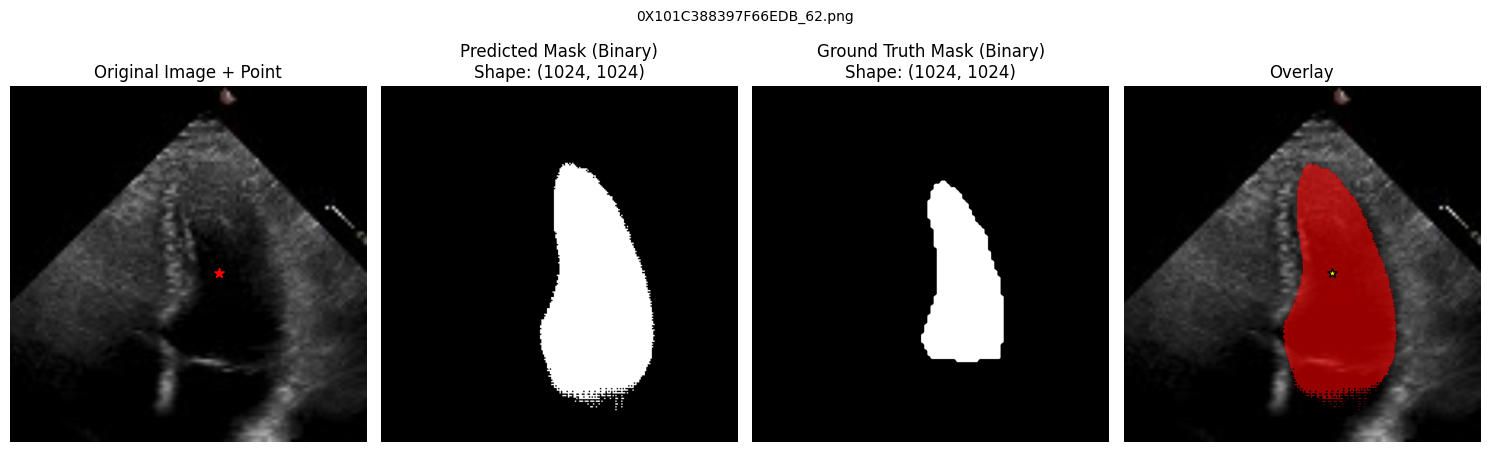


--- Sample 3 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[515, 498]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 126037 pixels


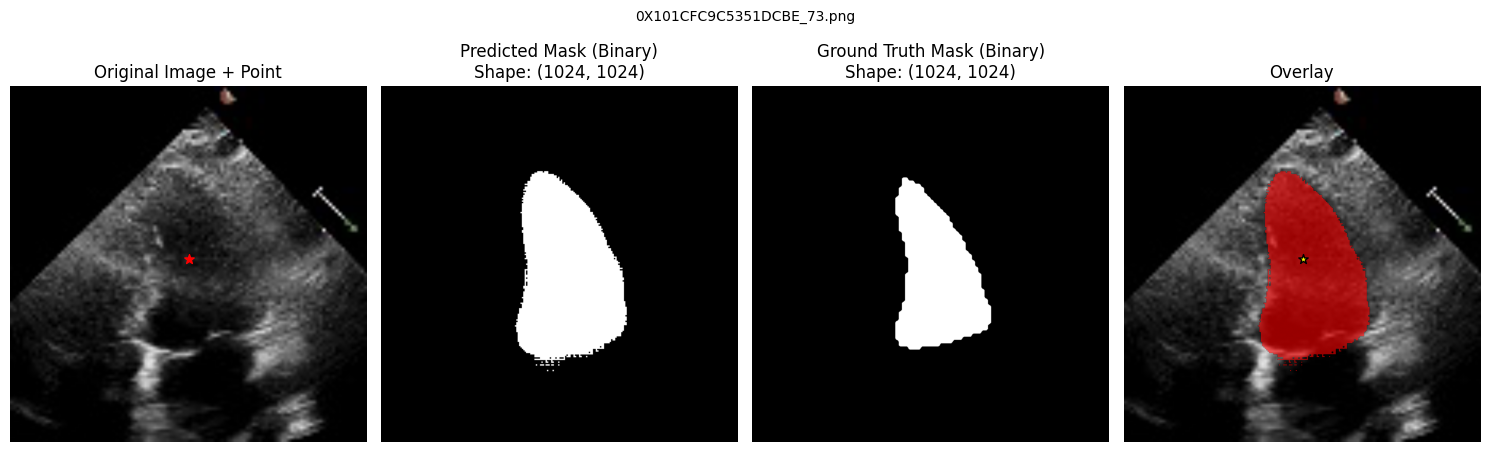


--- Sample 4 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[540, 432]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 86268 pixels


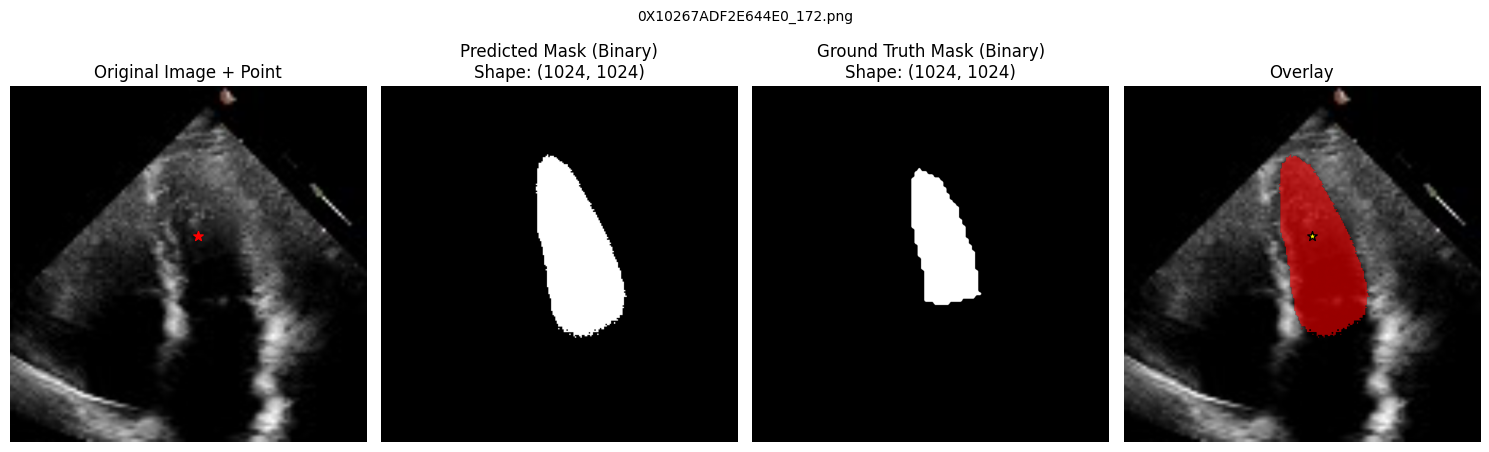


--- Sample 5 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[659, 489]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 124414 pixels


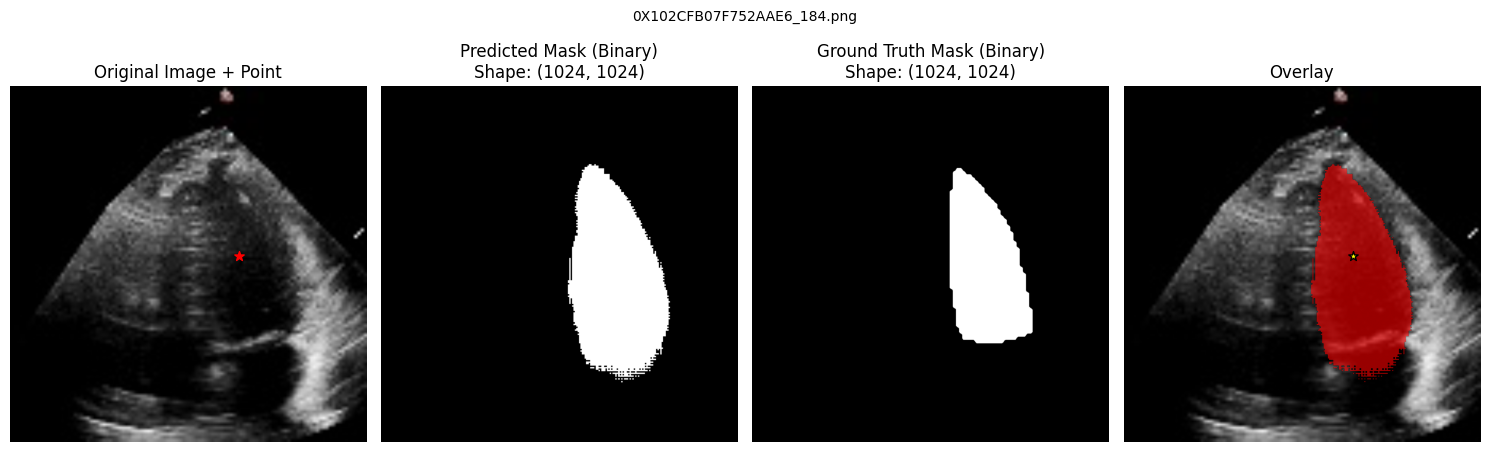


--- Sample 6 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[496, 357]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 140996 pixels


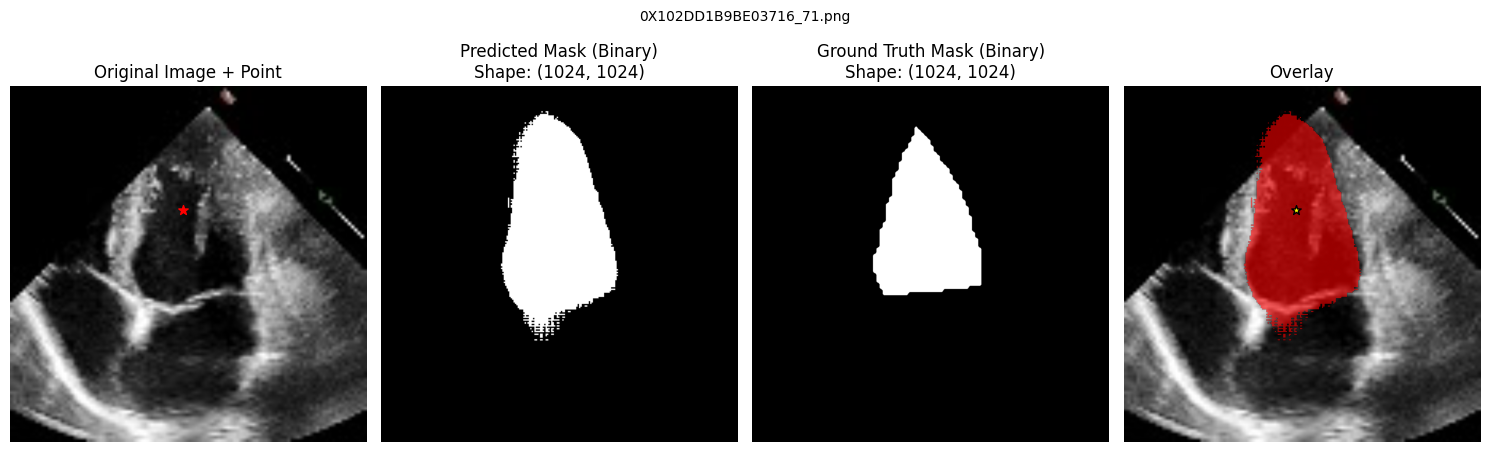


--- Sample 7 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[527, 356]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 119904 pixels


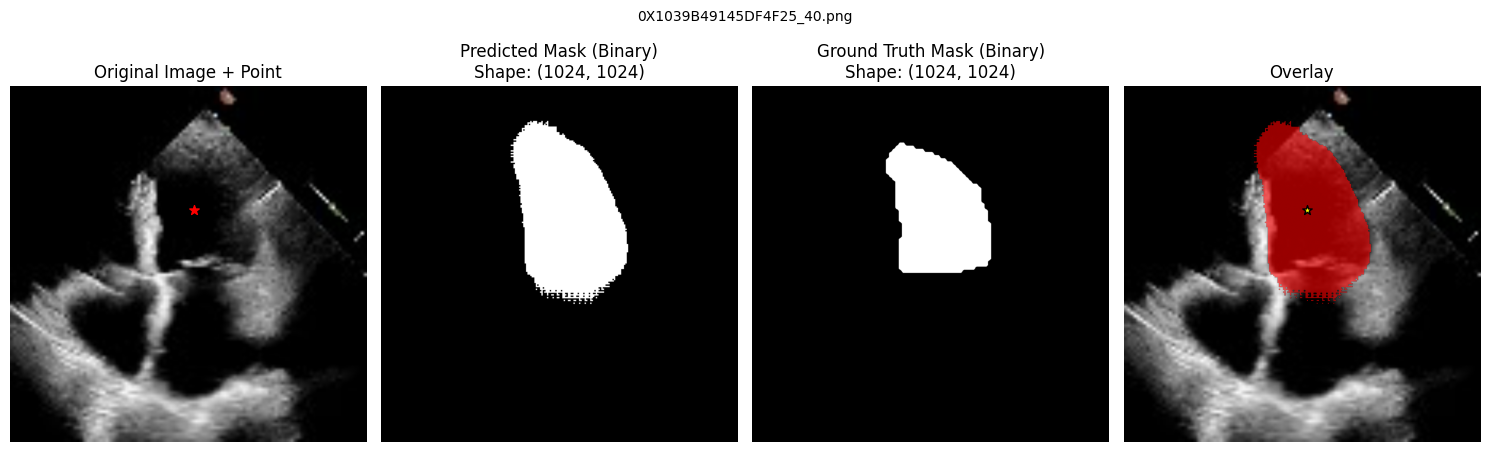


--- Sample 8 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[467, 419]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 109412 pixels


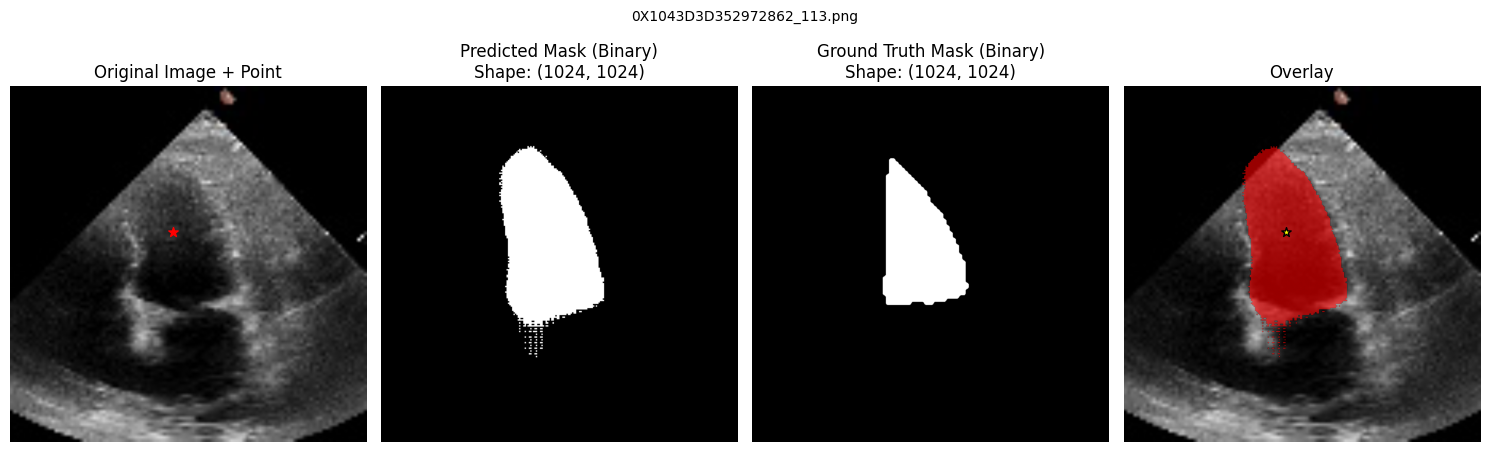


--- Sample 9 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[588, 375]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 132785 pixels


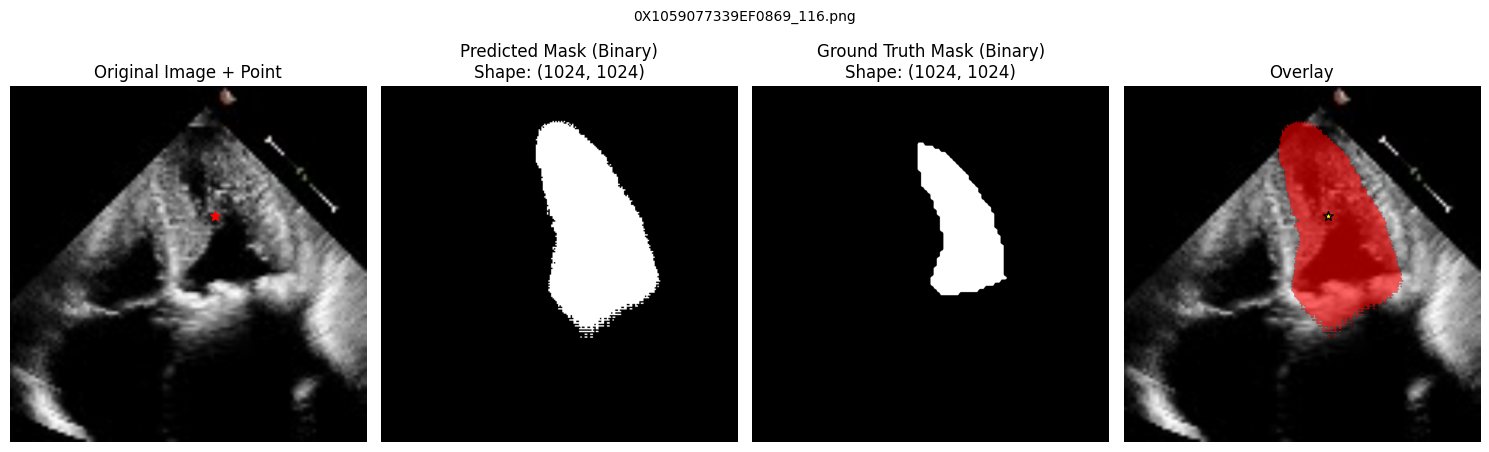


--- Sample 10 ---
Image shape: torch.Size([3, 1024, 1024])
Point coordinates: [[673, 519]]
Raw predicted mask shape: torch.Size([1, 3, 256, 256])
Image shape: (1024, 1024, 3)
Original pred mask shape: (3, 256, 256)
Final binary mask shape: (1024, 1024)
Mask coverage: 151706 pixels


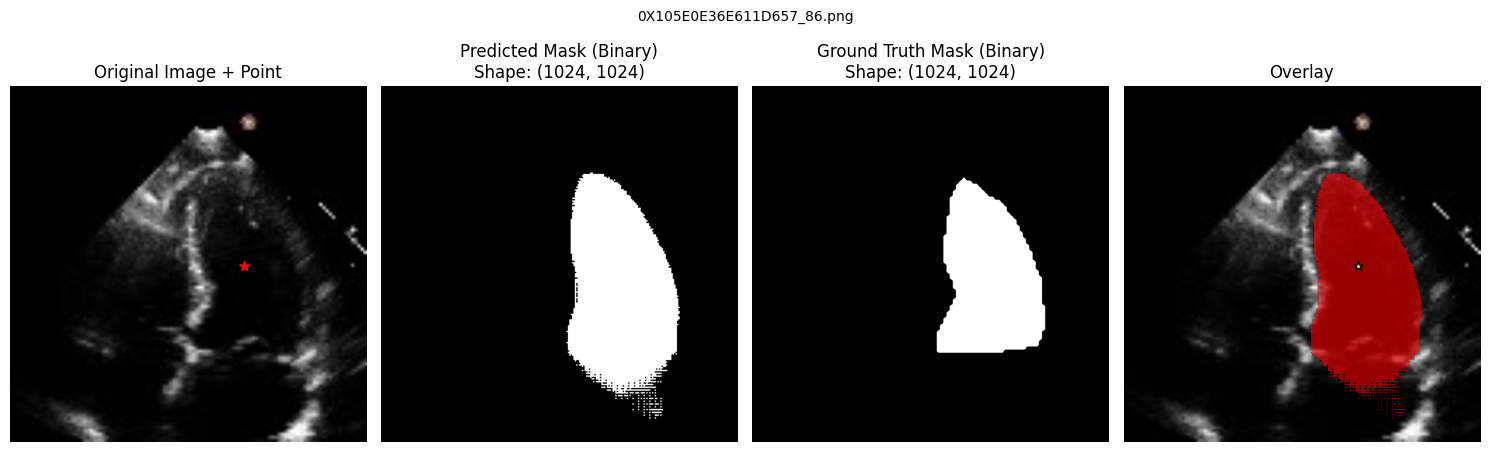

In [ ]:
load_checkpoint(model, optimizer, "./sam_ultrasound_checkpoints/best_model.pt", device)

run_sam_inference(val_dataset, model, processor, device, num_examples=10, batch_size=1)


In [12]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def dice_coefficient(pred_mask, true_mask, smooth=1e-6):
    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().numpy()
    if torch.is_tensor(true_mask):
        true_mask = true_mask.cpu().numpy()
    
    pred_binary = (pred_mask > 0.5).astype(np.float32)
    true_binary = (true_mask > 0.5).astype(np.float32)
    
    intersection = np.sum(pred_binary * true_binary)
    total = np.sum(pred_binary) + np.sum(true_binary)
    
    dice_score = (2.0 * intersection + smooth) / (total + smooth)
    
    return dice_score

def iou_coefficient(pred_mask, true_mask, smooth=1e-6):
    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().numpy()
    if torch.is_tensor(true_mask):
        true_mask = true_mask.cpu().numpy()
    
    pred_binary = (pred_mask > 0.5).astype(np.float32)
    true_binary = (true_mask > 0.5).astype(np.float32)
    
    intersection = np.sum(pred_binary * true_binary)
    union = np.sum(pred_binary) + np.sum(true_binary) - intersection
    
    iou_score = (intersection + smooth) / (union + smooth)
    
    return iou_score

def precision_recall_f1(pred_mask, true_mask, smooth=1e-6):
    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().numpy()
    if torch.is_tensor(true_mask):
        true_mask = true_mask.cpu().numpy()
    
    pred_binary = (pred_mask > 0.5).astype(np.float32)
    true_binary = (true_mask > 0.5).astype(np.float32)
    
    tp = np.sum(pred_binary * true_binary)
    fp = np.sum(pred_binary * (1 - true_binary))
    fn = np.sum((1 - pred_binary) * true_binary)
    
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    f1_score = (2 * precision * recall + smooth) / (precision + recall + smooth)
    
    return precision, recall, f1_score

def evaluate_sam_model(model, processor, dataset, device, num_samples=None, batch_size=1, 
                      save_visualizations=False, visualization_dir="./eval_visualizations"):
    model.eval()
    
    if num_samples is None:
        num_samples = len(dataset)
    else:
        num_samples = min(num_samples, len(dataset))
    
    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    if save_visualizations:
        import os
        os.makedirs(visualization_dir, exist_ok=True)
    
    print(f"Evaluating model on {num_samples} samples...")
    
    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        batch_indices = range(i, end_idx)
        
        batch_images = []
        batch_coords = []
        batch_samples = []
        
        for idx in batch_indices:
            sample = dataset[idx]
            batch_images.append(sample["image"])
            batch_coords.append(sample["point_coords"])
            batch_samples.append(sample)
        
        try:
            inputs = processor(
                images=batch_images,
                input_points=batch_coords,
                return_tensors="pt",
                do_rescale=False,
                padding="longest"
            ).to(device)
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            pred_masks = outputs.pred_masks.cpu()
            
            for j, (sample, raw_pred_mask) in enumerate(zip(batch_samples, pred_masks)):
                actual_idx = i + j
                
                pred_mask = torch.sigmoid(raw_pred_mask.squeeze()).numpy()
                if len(pred_mask.shape) == 3:
                    pred_mask = pred_mask[0]
                
                true_mask = sample["mask"].squeeze().numpy()
                if len(true_mask.shape) == 3:
                    true_mask = true_mask[0]
                
                if pred_mask.shape != true_mask.shape:
                    scale_y = true_mask.shape[0] / pred_mask.shape[0]
                    scale_x = true_mask.shape[1] / pred_mask.shape[1]
                    pred_mask = zoom(pred_mask, (scale_y, scale_x), order=1)  
                
                dice_score = dice_coefficient(pred_mask, true_mask)
                iou_score = iou_coefficient(pred_mask, true_mask)
                precision, recall, f1_score = precision_recall_f1(pred_mask, true_mask)
                
                dice_scores.append(dice_score)
                iou_scores.append(iou_score)
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1_score)
                
                if (actual_idx + 1) % 50 == 0:
                    print(f"Processed {actual_idx + 1}/{num_samples} samples. "
                          f"Current avg Dice: {np.mean(dice_scores):.4f}")
                
                if save_visualizations and (actual_idx < 10 or actual_idx % 100 == 0):
                    save_evaluation_visualization(
                        sample["image"], pred_mask, true_mask, 
                        sample["point_coords"], actual_idx,
                        dice_score, iou_score, f1_score,
                        visualization_dir
                    )
                
        except torch.cuda.OutOfMemoryError:
            print(f"CUDA OOM error at batch starting with sample {i}. Skipping batch...")
            torch.cuda.empty_cache()
            continue
        except Exception as e:
            print(f"Error processing batch starting with sample {i}: {e}")
            continue
        
        if i % (batch_size * 10) == 0:
            torch.cuda.empty_cache()
    
    results = {
        'dice_mean': np.mean(dice_scores),
        'dice_std': np.std(dice_scores),
        'dice_median': np.median(dice_scores),
        'iou_mean': np.mean(iou_scores),
        'iou_std': np.std(iou_scores),
        'iou_median': np.median(iou_scores),
        'precision_mean': np.mean(precision_scores),
        'precision_std': np.std(precision_scores),
        'recall_mean': np.mean(recall_scores),
        'recall_std': np.std(recall_scores),
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'num_samples': len(dice_scores),
        'dice_scores': dice_scores,
        'iou_scores': iou_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'f1_scores': f1_scores
    }
    
    return results

def save_evaluation_visualization(image_tensor, pred_mask, true_mask, coords, 
                                sample_idx, dice_score, iou_score, f1_score, save_dir):

    image = image_tensor.permute(1, 2, 0).numpy()
    
    pred_binary = (pred_mask > 0.5).astype(np.float32)
    true_binary = (true_mask > 0.5).astype(np.float32)
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 5, 1)
    plt.imshow(image)
    plt.scatter(coords[0][0], coords[0][1], c='red', s=100, marker='*', 
                edgecolors='white', linewidth=2)
    plt.title("Original Image + Point")
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(pred_binary, cmap="gray")
    plt.title(f"Predicted Mask\n{np.sum(pred_binary)} pixels")
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(true_binary, cmap="gray")
    plt.title(f"Ground Truth Mask\n{np.sum(true_binary)} pixels")
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(image)
    overlay = np.zeros((*pred_binary.shape, 4))
    overlay[pred_binary > 0.5] = [1, 0, 0, 0.6]  
    overlay[true_binary > 0.5] = [0, 1, 0, 0.6] 
    overlap = (pred_binary > 0.5) & (true_binary > 0.5)
    overlay[overlap] = [1, 1, 0, 0.6] 
    plt.imshow(overlay)
    plt.scatter(coords[0][0], coords[0][1], c='white', s=100, marker='*', 
                edgecolors='black', linewidth=2)
    plt.title("Overlay\n(Red: Pred, Green: GT, Yellow: Overlap)")
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    diff = pred_binary - true_binary
    plt.imshow(diff, cmap="RdBu", vmin=-1, vmax=1)
    plt.colorbar(shrink=0.6)
    plt.title("Difference\n(Blue: FN, Red: FP)")
    plt.axis('off')
    
    plt.suptitle(f"Sample {sample_idx} - Dice: {dice_score:.3f}, IoU: {iou_score:.3f}, F1: {f1_score:.3f}", 
                 fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/evaluation_sample_{sample_idx:04d}.png", 
                dpi=150, bbox_inches='tight')
    plt.close()

def print_evaluation_results(results):
    """
    Print comprehensive evaluation results.
    """
    print("\n" + "="*60)
    print("SAM MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"Number of samples evaluated: {results['num_samples']}")
    print()
    
    print("DICE SIMILARITY COEFFICIENT:")
    print(f"  Mean:   {results['dice_mean']:.4f} ± {results['dice_std']:.4f}")
    print(f"  Median: {results['dice_median']:.4f}")
    print(f"  Min:    {np.min(results['dice_scores']):.4f}")
    print(f"  Max:    {np.max(results['dice_scores']):.4f}")
    print()
    
    print("INTERSECTION OVER UNION (IoU):")
    print(f"  Mean:   {results['iou_mean']:.4f} ± {results['iou_std']:.4f}")
    print(f"  Median: {results['iou_median']:.4f}")
    print(f"  Min:    {np.min(results['iou_scores']):.4f}")
    print(f"  Max:    {np.max(results['iou_scores']):.4f}")
    print()
    
    print("PRECISION:")
    print(f"  Mean:   {results['precision_mean']:.4f} ± {results['precision_std']:.4f}")
    print()
    
    print("RECALL:")
    print(f"  Mean:   {results['recall_mean']:.4f} ± {results['recall_std']:.4f}")
    print()
    
    print("F1-SCORE:")
    print(f"  Mean:   {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
    print()
    
    # Performance categories
    excellent_dice = np.sum(np.array(results['dice_scores']) >= 0.9)
    good_dice = np.sum((np.array(results['dice_scores']) >= 0.7) & 
                      (np.array(results['dice_scores']) < 0.9))
    poor_dice = np.sum(np.array(results['dice_scores']) < 0.5)
    
    print("PERFORMANCE DISTRIBUTION (Dice Score):")
    print(f"  Excellent (≥0.9): {excellent_dice} samples ({excellent_dice/results['num_samples']*100:.1f}%)")
    print(f"  Good (0.7-0.9):   {good_dice} samples ({good_dice/results['num_samples']*100:.1f}%)")
    print(f"  Poor (<0.5):      {poor_dice} samples ({poor_dice/results['num_samples']*100:.1f}%)")
    print("="*60)

def plot_evaluation_metrics(results, save_path=None):
    """
    Plot histograms of evaluation metrics.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Dice scores
    axes[0, 0].hist(results['dice_scores'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(results['dice_mean'], color='red', linestyle='--', 
                       label=f'Mean: {results["dice_mean"]:.3f}')
    axes[0, 0].set_title('Dice Similarity Coefficient')
    axes[0, 0].set_xlabel('Dice Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # IoU scores
    axes[0, 1].hist(results['iou_scores'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(results['iou_mean'], color='red', linestyle='--', 
                       label=f'Mean: {results["iou_mean"]:.3f}')
    axes[0, 1].set_title('Intersection over Union (IoU)')
    axes[0, 1].set_xlabel('IoU Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 scores
    axes[0, 2].hist(results['f1_scores'], bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].axvline(results['f1_mean'], color='red', linestyle='--', 
                       label=f'Mean: {results["f1_mean"]:.3f}')
    axes[0, 2].set_title('F1-Score')
    axes[0, 2].set_xlabel('F1 Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].hist(results['precision_scores'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(results['precision_mean'], color='red', linestyle='--', 
                       label=f'Mean: {results["precision_mean"]:.3f}')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Precision')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].hist(results['recall_scores'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    axes[1, 1].axvline(results['recall_mean'], color='red', linestyle='--', 
                       label=f'Mean: {results["recall_mean"]:.3f}')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Scatter plot: Dice vs IoU
    axes[1, 2].scatter(results['dice_scores'], results['iou_scores'], alpha=0.6, color='teal')
    axes[1, 2].set_title('Dice vs IoU Correlation')
    axes[1, 2].set_xlabel('Dice Score')
    axes[1, 2].set_ylabel('IoU Score')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Calculate correlation
    correlation = np.corrcoef(results['dice_scores'], results['iou_scores'])[0, 1]
    axes[1, 2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                    transform=axes[1, 2].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Metrics plot saved to {save_path}")
    
    plt.show()

In [ ]:
evaluation_results = evaluate_cardiac_parameters(
    test_dataset, model, processor, device, num_samples=len(test_dataset)  
)
    
print_evaluation_results(evaluation_results)

Evaluating model on 42 samples...

SAM MODEL EVALUATION RESULTS
Number of samples evaluated: 42

DICE SIMILARITY COEFFICIENT:
  Mean:   0.7911 ± 0.0815
  Median: 0.7939
  Min:    0.6001
  Max:    0.9455

INTERSECTION OVER UNION (IoU):
  Mean:   0.6618 ± 0.1098
  Median: 0.6583
  Min:    0.4286
  Max:    0.8967

PRECISION:
  Mean:   0.6642 ± 0.1136

RECALL:
  Mean:   0.9966 ± 0.0100

F1-SCORE:
  Mean:   0.7911 ± 0.0815

PERFORMANCE DISTRIBUTION (Dice Score):
  Excellent (≥0.9): 1 samples (2.4%)
  Good (0.7-0.9):   34 samples (81.0%)
  Poor (<0.5):      0 samples (0.0%)
Metrics plot saved to ./evaluation_metrics.png


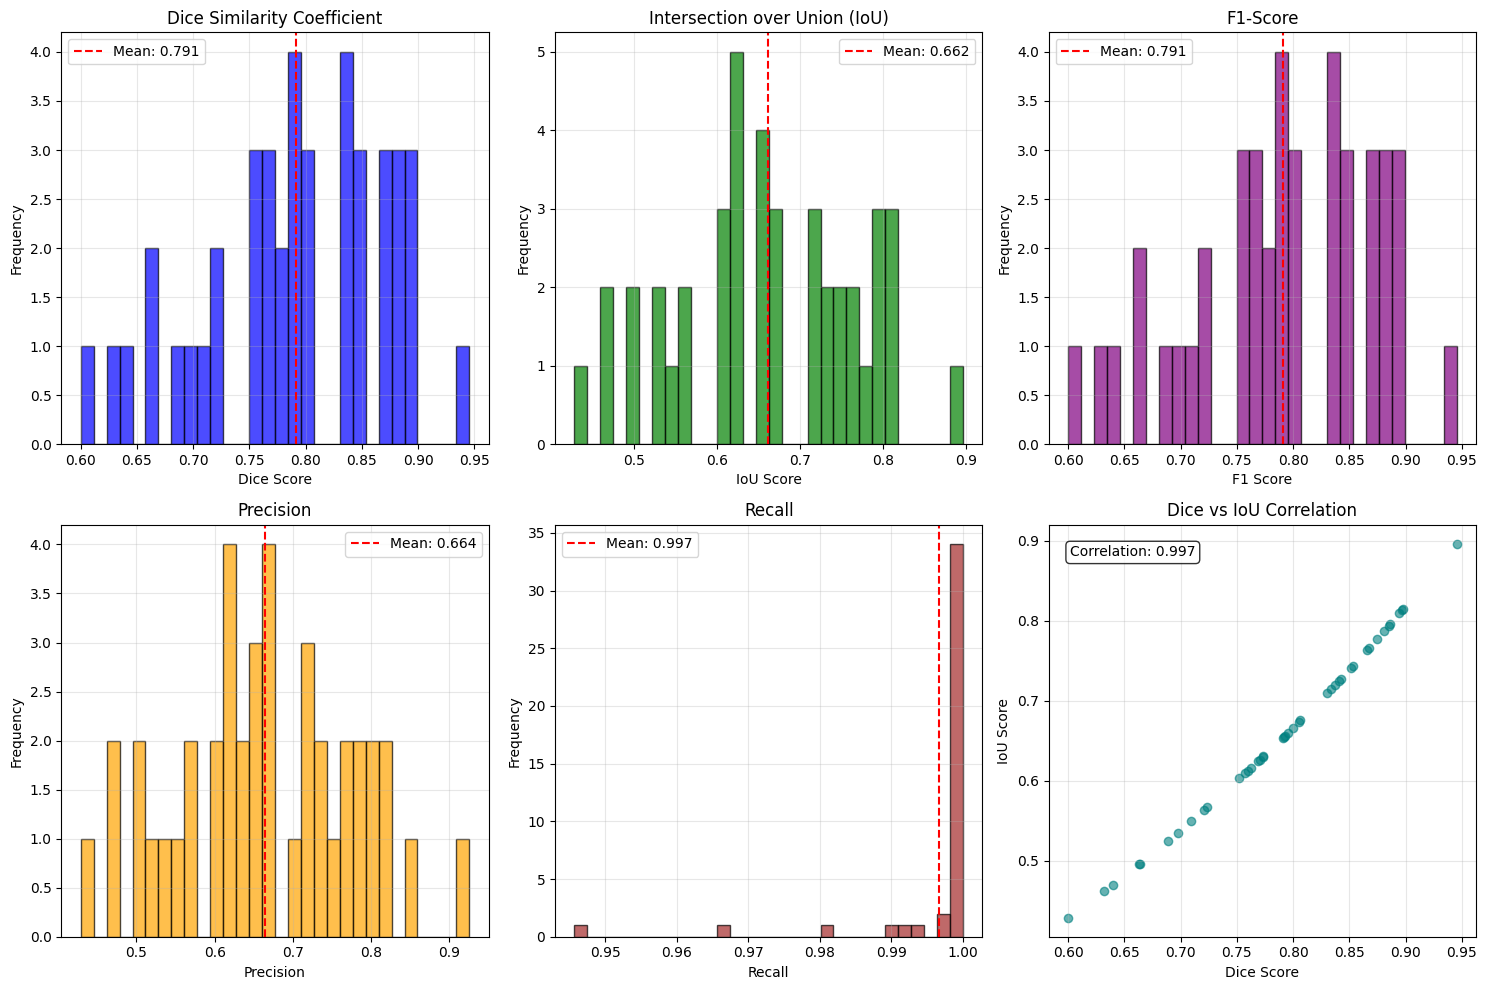

In [15]:
# After training, evaluate your model
results = evaluate_sam_model(
    model=model,
    processor=processor, 
    dataset=test_dataset,  # or test_dataset
    device=device,
    num_samples=42,  # None for all samples, or specify a number
    batch_size=1,
    save_visualizations=True
)

# Print detailed results
print_evaluation_results(results)

# Plot metrics histograms
plot_evaluation_metrics(results, save_path="./evaluation_metrics.png")

In [1]:
print("hello")

hello
